In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import imageio as Image
import cv2


In [2]:
import cv2
import os

# Define the directory containing the images
directory = "/kaggle/input/tomato-disease-multiple-sources/train"

# Get the list of files in the directory
train_files = os.listdir(directory)

In [3]:
train_files

['Late_blight',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Septoria_leaf_spot',
 'Early_blight',
 'Spider_mites Two-spotted_spider_mite',
 'powdery_mildew',
 'healthy',
 'Bacterial_spot',
 'Target_Spot',
 'Tomato_mosaic_virus',
 'Leaf_Mold']

In [4]:
import cv2
import os

train_images = []
train_labels = []

for label in train_files:
    images_dir = os.listdir(f'{directory}/{label}')
    
    for image in images_dir:
        # Read the image from the directory
        img = cv2.imread(f'{directory}/{label}/{image}')
        if img is not None:
            # Resize the image to 64x64 pixels
            img_resized = cv2.resize(img, (64, 64))
            # Append the resized image and label to the lists
            train_images.append(img_resized)
            train_labels.append(label)


In [13]:
# Define the directory containing the images
test_directory = "/kaggle/input/tomato-disease-multiple-sources/valid"

# Get the list of files in the directory
test_files = os.listdir(directory)


test_images = []
test_labels = []

for label in test_files:
    images_dir = os.listdir(f'{test_directory}/{label}')
    
    for image in images_dir:
        # Read the image from the directory
        img = cv2.imread(f'{test_directory}/{label}/{image}')
        if img is not None:
            # Resize the image to 64x64 pixels
            img_resized = cv2.resize(img, (64, 64))
            # Append the resized image and label to the lists
            test_images.append(img_resized)
            test_labels.append(label)
    

libpng error: Read Error


In [14]:
# Step 1: Identify unique labels and sort them (optional)
unique_labels = sorted(set(train_labels))

# Step 2: Create a mapping dictionary
label_to_number = {label: i for i, label in enumerate(unique_labels)}

# Step 3: Convert all labels
train_numeric_labels = [label_to_number[label] for label in train_labels]
test_numeric_labels = [label_to_number[label] for label in test_labels]

print(label_to_number)  # To see the mapping


{'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato_mosaic_virus': 8, 'healthy': 9, 'powdery_mildew': 10}


In [15]:
train_images[0].shape

(64, 64, 3)

In [16]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models

import cv2
import numpy as np

'''# Convert list of images to a NumPy array
def convert_to_array(images):
    # Convert each image to a numpy array and stack them into a single array
    if isinstance(images, list):
        # Assuming images are either paths or already loaded in some format compatible with OpenCV
        images = [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) if isinstance(img, str) else img for img in images]
    return np.stack(images)

# Function to resize images using OpenCV
def resize_images(images, new_size=(64, 64)):
    # Ensure images are in a NumPy array for processing
    if isinstance(images, list):
        images = convert_to_array(images)
    resized_images = np.zeros((images.shape[0], new_size[0], new_size[1], images.shape[3]), dtype=np.uint8)
    for i in range(images.shape[0]):
        resized_images[i] = cv2.resize(images[i], new_size, interpolation=cv2.INTER_AREA)
    return resized_images

# Example usage with lists of either image paths or preloaded images
# Load and resize images
train_images_resized = resize_images(train_images)
test_images_resized = resize_images(test_images)

# Assuming your images are loaded as lists and need conversion
train_images_resized = convert_to_array(train_images_resized)  # Convert to array if originally a list
test_images_resized = convert_to_array(test_images_resized)    # Convert to array if originally a list

# Normalize the images
train_images_resized = train_images_resized / 255.0
test_images_resized = test_images_resized / 255.0'''

# Normalize the images
train_images_resized = np.array(train_images) / 255.0
test_images_resized = np.array(test_images) / 255.0

# Define the CNN model
def create_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(11, activation='softmax')  # Assuming 10 classes
    ])
    return model



In [17]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_images_train, train_images_val, train_labels_train, train_labels_val = train_test_split(
    train_images_resized, train_numeric_labels, test_size=0.1, random_state=42
)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an image data generator for training with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,        # Random rotations
)

# Create a separate generator for validation data (without augmentation)
validation_datagen = ImageDataGenerator()

# Normalization should be applied to both sets of images (here assuming it was not already done)
train_datagen.fit(train_images_train)
validation_datagen.fit(train_images_train)  # Using training stats for validation normalization

# Prepare iterators
train_iterator = train_datagen.flow(train_images_train, train_labels_train, batch_size=128)
validation_iterator = validation_datagen.flow(train_images_val, train_labels_val, batch_size=128)


In [18]:
# Create a model instance
model = create_model((64, 64, 3))

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
import os

# Define a learning rate schedule (example: exponential decay)
# Define a learning rate schedule (example: exponential decay)
def lr_schedule(epoch, lr):
    if epoch > 10:
        return lr * 0.9
    return lr # Ensure the output is a float

# Set up the model checkpoint callback to save only the best model
checkpoint_path = "best_model.keras"  # Define the path where the model will be saved
model_checkpoint_callback = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    mode='max'  # 'max' because we want to maximize the validation accuracy
)

# Set up the learning rate scheduler callback
lr_scheduler_callback = LearningRateScheduler(lr_schedule, verbose=1)

# Train the model with the defined callbacks
history = model.fit(
    train_iterator,
    epochs=20,
    validation_data=validation_iterator,
    callbacks=[model_checkpoint_callback, lr_scheduler_callback]
)



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-04-23 16:43:07.706999: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7756: 7.1683, expected 6.3286
2024-04-23 16:43:07.707055: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7757: 7.1252, expected 6.28551
2024-04-23 16:43:07.707071: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7758: 6.90359, expected 6.06389
2024-04-23 16:43:07.707085: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7771: 7.35694, expected 6.51724
2024-04-23 16:43:07.707095: E external/local_xla/xla/service/gpu/buffer_compara

  3/182 ━━━━━━━━━━━━━━━━━━━━ 15s 85ms/step - accuracy: 0.0833 - loss: 2.4009

I0000 00:00:1713890590.696218     192 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 93/182 ━━━━━━━━━━━━━━━━━━━━ 14s 160ms/step - accuracy: 0.2503 - loss: 2.0901

2024-04-23 16:43:25.896631: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11799: 4.73029, expected 4.14701
2024-04-23 16:43:25.896688: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11861: 4.67844, expected 4.09517
2024-04-23 16:43:25.896704: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11862: 4.74655, expected 4.16328
2024-04-23 16:43:25.896721: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11945: 4.78923, expected 4.20596
2024-04-23 16:43:25.896736: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12022: 4.66862, expected 4.08534
2024-04-23 16:43:25.896748: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12097: 4.47678, expected 3.8935
2024-04-23 16:43:25.896761: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12493: 4.79414, expected 4.21086
2024-04-23 16:43:25.896774: 

181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.3368 - loss: 1.8800

2024-04-23 16:43:41.808989: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 6.39104, expected 5.53551
2024-04-23 16:43:41.809042: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 7.13787, expected 6.28233
2024-04-23 16:43:41.809051: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 7.41132, expected 6.55578
2024-04-23 16:43:41.809059: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 7.16988, expected 6.31434
2024-04-23 16:43:41.809066: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 7.37699, expected 6.52145
2024-04-23 16:43:41.809074: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 7.04243, expected 6.18689
2024-04-23 16:43:41.809081: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.77202, expected 5.91648
2024-04-23 16:43:41.809089: E external/local_xla/xla/se


Epoch 1: val_accuracy improved from -inf to 0.58043, saving model to best_model.keras
182/182 ━━━━━━━━━━━━━━━━━━━━ 39s 175ms/step - accuracy: 0.3384 - loss: 1.8761 - val_accuracy: 0.5804 - val_loss: 1.3032 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/20
181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.6593 - loss: 1.0158
Epoch 2: val_accuracy improved from 0.58043 to 0.62220, saving model to best_model.keras
182/182 ━━━━━━━━━━━━━━━━━━━━ 30s 161ms/step - accuracy: 0.6595 - loss: 1.0152 - val_accuracy: 0.6222 - val_loss: 1.3411 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/20
181/182 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7202 - loss: 0.8222
Epoch 3: val_accuracy improved from 0.62220 to 0.65429, saving model to best_model.keras
182/182 ━━━━━━━━━━━━━━━━━━━━ 31s 162ms/step - accuracy: 0.7203 - loss: 0.8219 - val_accuracy: 0.6543 - val_loss

In [19]:
# Optional: Load the best model saved after training
best_model = tf.keras.models.load_model(checkpoint_path)
# Evaluate the best model
test_iterator = validation_datagen.flow(test_images_resized, test_numeric_labels, batch_size=32, shuffle=False)
test_loss, test_acc = best_model.evaluate(test_iterator)
print(f"Test accuracy of the best model: {test_acc}, Test loss: {test_loss}")

2024-04-23 16:53:26.606945: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 6.39927, expected 5.58886
2024-04-23 16:53:26.607012: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.92185, expected 5.11143
2024-04-23 16:53:26.607027: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.99669, expected 5.18628
2024-04-23 16:53:26.607040: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.48891, expected 5.6785
2024-04-23 16:53:26.607050: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 6.18882, expected 5.37841
2024-04-23 16:53:26.607060: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.76108, expected 5.95067
2024-04-23 16:53:26.607070: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.21291, expected 5.4025
2024-04-23 16:53:26.607080: E external/local_xla/xla/serv

200/209 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7969 - loss: 0.6693

2024-04-23 16:53:27.934187: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3886: 6.24401, expected 5.49932
2024-04-23 16:53:27.934258: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3907: 6.22152, expected 5.47682
2024-04-23 16:53:27.934274: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3912: 5.78222, expected 5.03753
2024-04-23 16:53:27.934286: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3913: 6.13528, expected 5.39059
2024-04-23 16:53:27.934296: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3925: 6.00896, expected 5.26427
2024-04-23 16:53:27.934306: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3927: 5.83236, expected 5.08767
2024-04-23 16:53:27.934317: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3948: 6.00493, expected 5.26024
2024-04-23 16:53:27.934327: E exte

209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7987 - loss: 0.6714
Test accuracy of the best model: 0.8319616913795471, Test loss: 1.367741346359253


In [20]:
# Predict the labels for the test set
predicted_labels = model.predict(test_images_resized)
predicted_labels = np.argmax(predicted_labels, axis=1)  # Convert probabilities to class labels


209/209 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


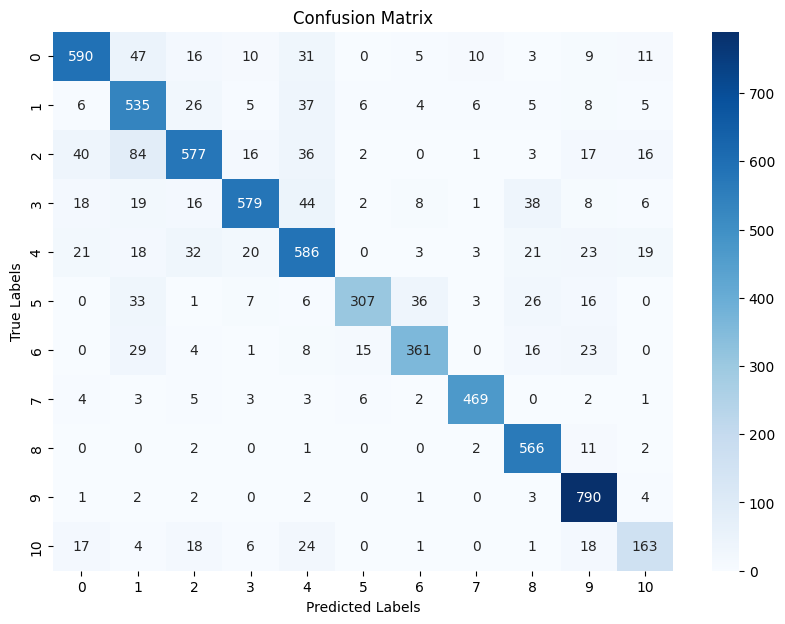

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(test_numeric_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


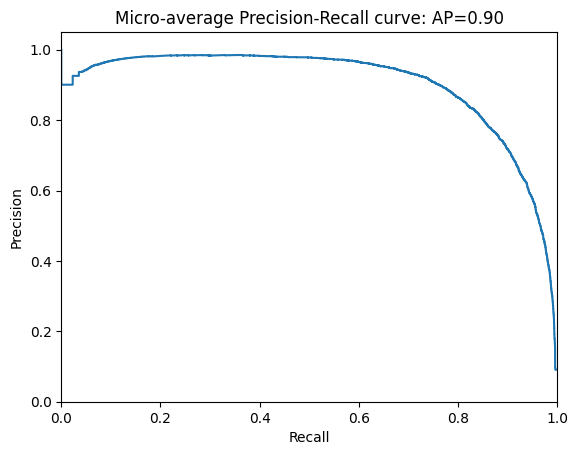

In [22]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

# Assuming you have more than 2 classes and the labels are in 'train_labels'
n_classes = len(np.unique(test_numeric_labels))
y_test_bin = label_binarize(test_numeric_labels, classes=np.arange(n_classes))

# Make predictions for each class
y_score = model.predict(test_images_resized)

# Compute the micro-average precision-recall curve
precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_score.ravel())
average_precision = average_precision_score(y_test_bin, y_score, average="micro")

# Plot the micro-average precision-recall curve
plt.figure()
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Micro-average Precision-Recall curve: AP={average_precision:0.2f}')
plt.show()


209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


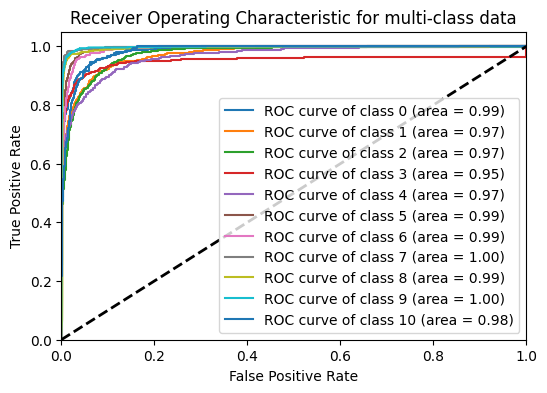

In [24]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

# Binarize the labels
n_classes = len(np.unique(test_numeric_labels))
y_test_bin = label_binarize(test_numeric_labels, classes=np.arange(n_classes))

# Make predictions for each class
y_score = model.predict(test_images_resized)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(6, 4))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()
